# Random Forests Model for UFC Predictor. 

In [23]:
# Imports
# data Analysis
import pandas as pd
import numpy as np
import random as rng
import xgboost as xgb
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#SciKit Learn Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

finalout.csv



## Data Acquistion
For this project, acquiring data proved to be rather challenging.  The UFC does not provide well detailed fight data for any fight before 2013, and so we had to write several python scripts in order to scrape data from the UFC website as well as external sources and clean them into a final csv. The Python scripts can be found in the accompanying Datascripts folder.  

In [3]:
data = pd.read_csv("../input/finalout.csv")

## Data Description
#### Features
Our dataset contains 879 features. We have aggregated roundwise data for every UFC fight since 2013 (Roughly 1500 fights overall) and have summed the fighter's record previous to each fight assuming every fighter started from 0 in 2013. This can be shown as below.

#### Types of Features
Our dataset is largely numeric, Record being the the exception as the record is an array of Wins.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Columns: 879 entries, BlueRecord to winner
dtypes: float64(870), int64(4), object(5)
memory usage: 9.9+ MB


In [5]:
data.describe()

,Blue_ID,B_R1_Grappling_Reversals_Landed,B_R1_Grappling_Standups_Landed,B_R1_Grappling_Submissions_Attempts,B_R1_Grappling_Takedowns_Attempts,B_R1_Grappling_Takedowns_Landed,B_R1_Strikes_Body Significant Strikes_Attempts,B_R1_Strikes_Body Significant Strikes_Landed,B_R1_Strikes_Body Total Strikes_Attempts,B_R1_Strikes_Body Total Strikes_Landed,...,R_R5_TIP_Distance Time,R_R5_TIP_Ground Control Time,R_R5_TIP_Ground Time,R_R5_TIP_Guard Control Time,R_R5_TIP_Half Guard Control Time,R_R5_TIP_Misc. Ground Control Time,R_R5_TIP_Mount Control Time,R_R5_TIP_Neutral Time,R_R5_TIP_Side Control Time,R_R5_TIP_Standing Time
count,1477.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,...,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,1964.633040,0.036810,0.896728,0.431493,2.986708,1.210634,11.490798,7.623722,16.317996,12.302658,...,211.965278,34.062500,66.604167,5.527778,4.319444,5.138889,12.097222,224.965278,4.562500,263.069444
std,666.949141,0.193748,1.255722,0.830527,3.987291,1.754832,12.363002,8.352246,17.120445,13.932885,...,139.412374,68.819742,94.574736,22.374419,12.854023,14.312013,36.429320,142.328509,19.698681,162.386212
min,129.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1755.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,5.000000,3.000000,...,110.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,126.750000,0.000000,139.000000
50%,2156.000000,0.000000,0.000000,0.000000,2.000000,1.000000,7.000000,5.000000,11.000000,8.000000,...,214.000000,0.000000,9.500000,0.000000,0.000000,0.000000,0.000000,232.000000,0.000000,291.000000
75%,2337.000000,0.000000,1.000000,1.000000,4.000000,2.000000,16.000000,10.750000,22.000000,17.000000,...,294.500000,47.500000,109.000000,0.000000,0.000000,0.000000,2.000000,299.000000,0.000000,300.000000
max,2882.000000,2.000000,9.000000,6.000000,33.000000,17.000000,91.000000,56.000000,156.000000,146.000000,...,647.000000,496.000000,529.000000,144.000000,91.000000,62.000000,264.000000,659.000000,128.000000,841.000000


In [6]:
data.describe(include=['O'])

,BlueRecord,Blue_Name,RedRecord,Red_Name,winner
count,1477,1477,1477,1477,1477
unique,137,719,154,633,4
top,[],Tim Means,[],Donald Cerrone,red
freq,499,8,342,11,867


### Some Notes to observe
1. Red Side seems to win slightly more than blue (867/1477 = 58.7%)
2. Donald Cerrone fights on Red side more than any other fighter, with 11 fights
3. Tim Means fights on Blue side more than any other fighter with 8
4. There are more fighters fighting debut fights. This statistic however could be skewed by the fact that our data set assumes debuts of every fighter in 2013

### Data Manipulations required
1. We need to analyse correlations between each feature and winner. 
2. We need to Convert our Record Array into a streak analysis  - temporarily dropped our Records Array instead
3. We need to correct our NaN enteries (generated for rounds that did not happen) - data.fillna replaces NaN with 0s

In [7]:
data.fillna(value=0,inplace=True)
backup = data.copy()
del data['Blue_Name']
del data['Red_Name']
del data['BlueRecord']
del data['RedRecord']
del data['Blue_ID']
del data['Red_ID']
# Dropping identifying characteristics of the rows

In [8]:
data.tail()

,B_R1_Grappling_Reversals_Landed,B_R1_Grappling_Standups_Landed,B_R1_Grappling_Submissions_Attempts,B_R1_Grappling_Takedowns_Attempts,B_R1_Grappling_Takedowns_Landed,B_R1_Strikes_Body Significant Strikes_Attempts,B_R1_Strikes_Body Significant Strikes_Landed,B_R1_Strikes_Body Total Strikes_Attempts,B_R1_Strikes_Body Total Strikes_Landed,B_R1_Strikes_Clinch Body Strikes_Attempts,...,R_R5_TIP_Ground Control Time,R_R5_TIP_Ground Time,R_R5_TIP_Guard Control Time,R_R5_TIP_Half Guard Control Time,R_R5_TIP_Misc. Ground Control Time,R_R5_TIP_Mount Control Time,R_R5_TIP_Neutral Time,R_R5_TIP_Side Control Time,R_R5_TIP_Standing Time,winner
1472,0.0,0.0,1.0,14.0,5.0,10.0,8.0,13.0,11.0,9.0,...,145.0,267.0,144.0,0.0,1.0,0.0,18.0,0.0,33.0,red
1473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,red
1474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,34.0,91.0,0.0,6.0,0.0,28.0,209.0,0.0,209.0,red
1475,0.0,4.0,1.0,10.0,4.0,26.0,19.0,27.0,20.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,red
1476,0.0,5.0,2.0,9.0,2.0,30.0,24.0,36.0,30.0,25.0,...,21.0,21.0,0.0,0.0,0.0,15.0,163.0,0.0,189.0,blue


In [9]:
data["winner"] = data["winner"].astype("category")

In [10]:
cat_columns = data.select_dtypes(['category']).columns
data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)

## Data Correlation
While it would otherwise be normal practise to draw a heatmap or correlation matrix of our data to look for linear relationships, this is highly illogical due to the sheer number of features we're currently looking at.  Instead we examine the n largest correlations with our dependent variable (winner) to look for linear relationships - as you can see from the plot below, the relationships (if they exist) are highly non-linear. This suggests that alterations to our Data Set are required. 

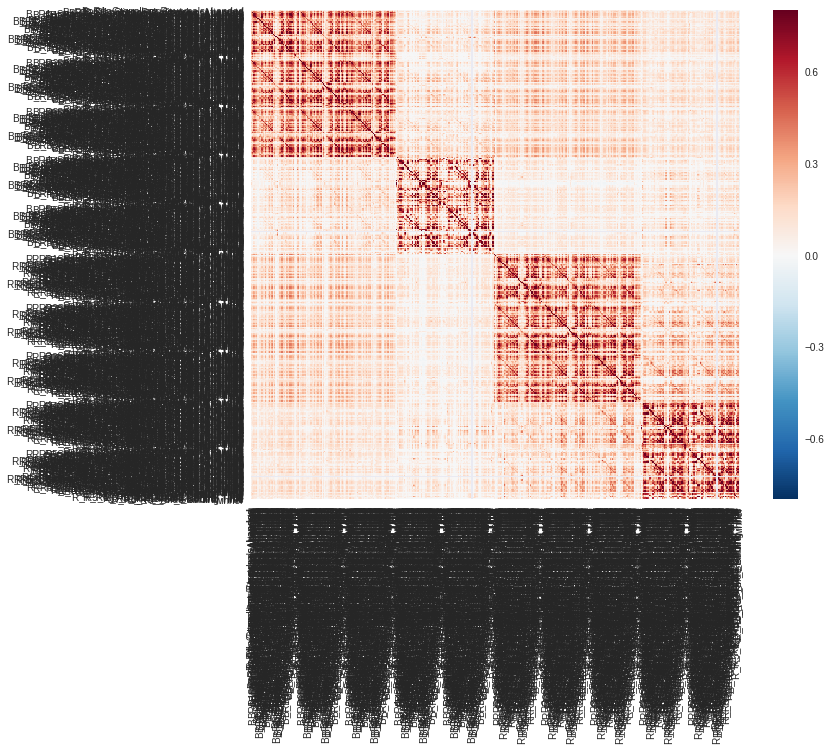

In [24]:
# Basic Correlation Matrix
# corrmat = data.corr()
# f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, vmax=.8, square=True);

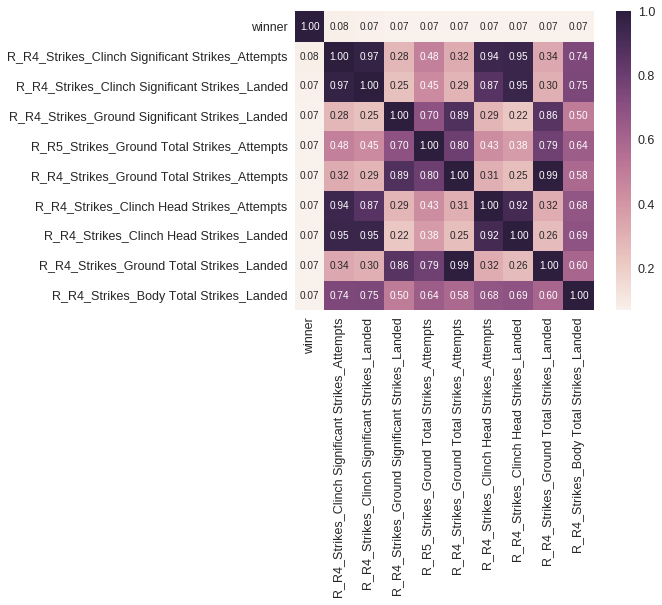

In [25]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'winner')['winner'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
X_all = data.drop(['winner'], axis=1)
y_all = data['winner']
X_train, X_test, Y_train, Y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=23)

## Modeling
We're evaluating the following models

1. Logistic Regression
2. Perceptron
3. Gaussian Naive Bayes
4. Random forests

In [13]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
print(accuracy_score(Y_test,Y_pred))
confusion_matrix(Y_test,Y_pred)

0.415540540541


array([[110,   0,   0,   4],
       [  1,   0,   0,   0],
       [  5,   0,   0,   0],
       [163,   0,   0,  13]])

### Random Forests
Ensemble methods like random forests are susceptible to Overfitting and it's difficult to determine the number of trees requires for the Forests. Also accuracy score is not a great estimator for general error rates so we're using the Out of the Box error rate instead. 
From the plot it's easy to see that the ideal number of estimators for our dataset is 111 and using 30 features per tree. 
Thus for our final Classifier we've picked the decision tree with those parameters

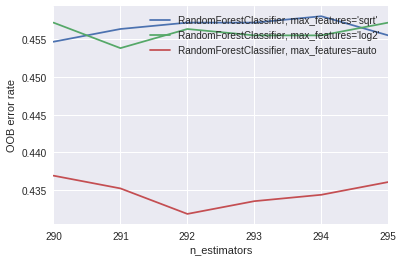

In [14]:
from collections import OrderedDict
#random_forest = RandomForestClassifier(n_estimators=1000)
#random_forest.fit(X_train, Y_train,oob_score=True )
#Y_pred = random_forest.predict(X_test)
#random_forest.score(X_train, Y_train)
RANDOM_STATE=123
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=auto",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 290
max_estimators = 295

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, Y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [15]:
randomfor = RandomForestClassifier(max_features="auto",
                               n_estimators = 292,
                               max_depth = None)
randomfor.fit(X_train,Y_train)
Y_pred = randomfor.predict(X_test)
print(accuracy_score(Y_test,Y_pred))
confusion_matrix(Y_test,Y_pred)

0.584459459459


array([[ 38,   0,   0,  76],
       [  1,   0,   0,   0],
       [  2,   0,   0,   3],
       [ 41,   0,   0, 135]])

In [16]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
print(accuracy_score(Y_test,Y_pred))
confusion_matrix(Y_test,Y_pred)

0.527027027027


array([[ 55,   1,   1,  57],
       [  0,   0,   0,   1],
       [  2,   0,   0,   3],
       [ 71,   0,   4, 101]])

In [17]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
print(accuracy_score(Y_test,Y_pred))
confusion_matrix(Y_test,Y_pred)

0.472972972973


array([[ 80,   1,   0,  33],
       [  1,   0,   0,   0],
       [  5,   0,   0,   0],
       [116,   0,   0,  60]])

In [18]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
print(accuracy_score(Y_test,Y_pred))
confusion_matrix(Y_test,Y_pred)

0.564189189189


array([[ 35,   0,   0,  79],
       [  0,   0,   0,   1],
       [  1,   0,   0,   4],
       [ 42,   0,   2, 132]])

In [19]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
print(accuracy_score(Y_test,Y_pred))
confusion_matrix(Y_test,Y_pred)

0.334459459459


array([[59,  0, 36, 19],
       [ 0,  0,  1,  0],
       [ 2,  0,  3,  0],
       [81,  4, 54, 37]])

In [20]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
print(accuracy_score(Y_test,Y_pred))
confusion_matrix(Y_test,Y_pred)

0.489864864865


array([[ 44,   0,   0,  70],
       [  0,   0,   0,   1],
       [  3,   0,   0,   2],
       [ 75,   0,   0, 101]])

In [21]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
print(accuracy_score(Y_test,Y_pred))
confusion_matrix(Y_test,Y_pred)

0.581081081081


array([[  0,   0,   0, 114],
       [  0,   0,   0,   1],
       [  0,   0,   0,   5],
       [  4,   0,   0, 172]])

In [22]:
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, Y_train)
Y_pred = gbm.predict(X_test)
print(accuracy_score(Y_test,Y_pred))
confusion_matrix(Y_test,Y_pred)

0.557432432432


array([[ 34,   0,   0,  80],
       [  0,   0,   0,   1],
       [  2,   0,   0,   3],
       [ 45,   0,   0, 131]])